# Cifar10 Outlier Detection
![demo](./demo.png)

In this example we will deploy an image classification model along with an outlier detector trained on the same dataset. For in depth details on creating an outlier detection model for your own dataset see the [alibi-detect project](https://github.com/SeldonIO/alibi-detect) and associated [documentation](https://docs.seldon.ai/alibi-detect). You can find details for this [CIFAR10 example in their documentation](https://docs.seldon.ai/alibi-detect/outlier-detection/examples/od_vae_cifar10) as well.


Prequisites:

  * [Knative eventing installed](https://knative.dev/docs/install/)
    * Ensure the istio-ingressgateway is exposed as a loadbalancer (no auth in this demo)
  * [Seldon Core installed](https://docs.seldon.io/projects/seldon-core/en/latest/workflow/install.html) 
    * Ensure you install for istio, e.g. for the helm chart `--set istio.enabled=true`
    
    Tested on GKE and Kind with Knative 1.10.1 and Istio 1.16.2

In [1]:
!pip install -r requirements_notebook.txt

Ensure istio gateway installed

In [2]:
!kubectl apply -f ../../../notebooks/resources/seldon-gateway.yaml

gateway.networking.istio.io/seldon-gateway unchanged


In [3]:
!cat ../../../notebooks/resources/seldon-gateway.yaml

apiVersion: networking.istio.io/v1alpha3
kind: Gateway
metadata:
  name: seldon-gateway
  namespace: istio-system
spec:
  selector:
    istio: ingressgateway # use istio default controller
  servers:
  - port:
      number: 80
      name: http
      protocol: HTTP
    hosts:
    - "*"


## Setup Resources

In [4]:
!kubectl create namespace cifar10

namespace/cifar10 created


In [5]:
%%writefile broker.yaml
apiVersion: eventing.knative.dev/v1
kind: Broker
metadata:
 name: default
 namespace: cifar10

Writing broker.yaml


In [6]:
!kubectl create -f broker.yaml

broker.eventing.knative.dev/default created


In [7]:
%%writefile event-display.yaml
apiVersion: apps/v1
kind: Deployment
metadata:
  name: hello-display
  namespace: cifar10
spec:
  replicas: 1
  selector:
    matchLabels: &labels
      app: hello-display
  template:
    metadata:
      labels: *labels
    spec:
      containers:
        - name: event-display
          image: gcr.io/knative-releases/knative.dev/eventing/cmd/event_display

---

kind: Service
apiVersion: v1
metadata:
  name: hello-display
  namespace: cifar10
spec:
  selector:
    app: hello-display
  ports:
  - protocol: TCP
    port: 80
    targetPort: 8080

Writing event-display.yaml


In [8]:
!kubectl apply -f event-display.yaml

deployment.apps/hello-display created
service/hello-display created


Create the SeldonDeployment image classification model for Cifar10. We add in a `logger` for requests - the default destination is the namespace Knative Broker.

In [9]:
%%writefile cifar10.yaml
apiVersion: machinelearning.seldon.io/v1
kind: SeldonDeployment
metadata:
  name: tfserving-cifar10
  namespace: cifar10
spec:
  protocol: tensorflow
  transport: rest
  predictors:
  - componentSpecs:
    - spec:
        containers:
        - args: 
          - --port=8500
          - --rest_api_port=8501
          - --model_name=resnet32
          - --model_base_path=gs://seldon-models/tfserving/cifar10/resnet32
          image: tensorflow/serving
          name: resnet32
          ports:
          - containerPort: 8501
            name: http
            protocol: TCP
    graph:
      name: resnet32
      type: MODEL
      endpoint:
        service_port: 8501
      logger:
        mode: all
        url: http://broker-ingress.knative-eventing.svc.cluster.local/cifar10/default
    name: model
    replicas: 1


Writing cifar10.yaml


In [10]:
!kubectl apply -f cifar10.yaml

seldondeployment.machinelearning.seldon.io/tfserving-cifar10 created


Create the pretrained VAE Cifar10 Outlier Detector. We forward replies to the message-dumper we started.

Here we configure `seldonio/alibi-detect-server` to use rclone for downloading the artifact. 
If `RCLONE_ENABLED=true` environmental variable is set or any of the environmental variables contain `RCLONE_CONFIG` in their name then rclone
will be used to download the artifacts. If `RCLONE_ENABLED=false` or no `RCLONE_CONFIG` variables are present then kfserving storage.py logic will be used to download the artifacts.

In [11]:
%%writefile cifar10od.yaml

apiVersion: v1
kind: Secret
metadata:
  name: seldon-rclone-secret
  namespace: cifar10    
type: Opaque
stringData:
  RCLONE_CONFIG_GS_TYPE: google cloud storage
  RCLONE_CONFIG_GS_ANONYMOUS: "true"

---            

apiVersion: serving.knative.dev/v1
kind: Service
metadata:
  name: vae-outlier
  namespace: cifar10
spec:
  template:
    metadata:
      annotations:
        autoscaling.knative.dev/minScale: "1"
    spec:
      containers:
      - image: seldonio/alibi-detect-server:1.19.0-dev
        imagePullPolicy: IfNotPresent
        args:
        - --model_name
        - cifar10od
        - --http_port
        - '8080'
        - --protocol
        - tensorflow.http
        - --storage_uri
        - gs://seldon-models/alibi-detect/od/OutlierVAE/cifar10
        - --reply_url
        - http://hello-display.cifar10
        - --event_type
        - io.seldon.serving.inference.outlier
        - --event_source
        - io.seldon.serving.cifar10od
        - OutlierDetector
        envFrom:
        - secretRef:
            name: seldon-rclone-secret

Writing cifar10od.yaml


In [12]:
!kubectl apply -f cifar10od.yaml

secret/seldon-rclone-secret created
service.serving.knative.dev/vae-outlier created


Create a Knative trigger to forward logging events to our Outlier Detector.

In [13]:
%%writefile trigger.yaml
apiVersion: eventing.knative.dev/v1
kind: Trigger
metadata:
  name: vaeoutlier-trigger
  namespace: cifar10
spec:
  broker: default
  filter:
    attributes:
      type: io.seldon.serving.inference.request
  subscriber:
    ref:
      apiVersion: serving.knative.dev/v1
      kind: Service
      name: vae-outlier
      namespace: cifar10


Writing trigger.yaml


In [14]:
!kubectl apply -f trigger.yaml

trigger.eventing.knative.dev/vaeoutlier-trigger created


Get the IP address of the Istio Ingress Gateway. This assumes you have installed istio with a LoadBalancer.

In [ ]:
CLUSTER_IPS = !(kubectl -n istio-system get service istio-ingressgateway -o jsonpath='{.status.loadBalancer.ingress[0].ip}')
CLUSTER_IP = CLUSTER_IPS[0]
print(CLUSTER_IP)

Optionally add an authorization token here if you need one.Acquiring this token will be dependent on your auth setup.

In [22]:
TOKEN = "Bearer <my token>"

If you are using Kind or Minikube you will need to port-forward to the istio ingressgateway and uncomment the following

In [15]:
CLUSTER_IP="localhost:8080"

In [16]:
SERVICE_HOSTNAMES = !(kubectl get ksvc -n cifar10 vae-outlier -o jsonpath='{.status.url}' | cut -d "/" -f 3)
SERVICE_HOSTNAME_VAEOD = SERVICE_HOSTNAMES[0]
print(SERVICE_HOSTNAME_VAEOD)

vae-outlier.cifar10.svc.cluster.local


In [36]:
import json

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

tf.keras.backend.clear_session()

import requests
from alibi_detect.utils.perturbation import apply_mask

train, test = tf.keras.datasets.cifar10.load_data()
X_train, y_train = train
X_test, y_test = test

X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)


def show(X):
    plt.imshow(X.reshape(32, 32, 3))
    plt.axis("off")
    plt.show()


def predict(X):
    formData = {"instances": X.tolist()}
    headers = {"Authorization": TOKEN}
    res = requests.post(
        "http://"
        + CLUSTER_IP
        + "/seldon/cifar10/tfserving-cifar10/v1/models/resnet32/:predict",
        json=formData,
        headers=headers,
    )
    if res.status_code == 200:
        return classes[np.array(res.json()["predictions"])[0].argmax()]
    else:
        print("Failed with ", res.status_code)
        return []

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


## Normal Prediction

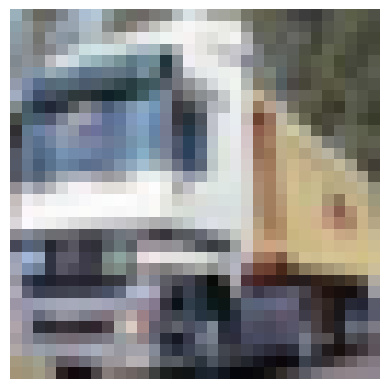

'truck'

In [24]:
idx = 1
X = X_train[idx : idx + 1]
show(X)
predict(X)

Lets check the message dumper for an outlier detection prediction. This should be false.

In [25]:
!kubectl logs -n cifar10 $(kubectl get pod -n cifar10 -l app=hello-display -o jsonpath='{.items[0].metadata.name}')

2025/12/12 15:00:08 failed to parse observability config from env, falling back to default config
2025/12/12 15:00:08 failed to correctly initialize otel resource, resouce may be missing some attributes: the environment variable "SYSTEM_NAMESPACE" is not set, not adding "k8s.namespace.name" to otel attributes
☁️  cloudevents.Event
Context Attributes,
  specversion: 1.0
  type: io.seldon.serving.inference.outlier
  source: io.seldon.serving.cifar10od
  id: 7740b269-da42-4e6f-a451-8ba8a239b97f
Extensions,
  endpoint: model
  inferenceservicename: tfserving-cifar10
  knativearrivaltime: 2025-12-12T15:03:13.825723818Z
  modelid: resnet32
  namespace: cifar10
  protocol: tensorflow
  requestid: 960f455d-8fee-4cb0-a560-5d2b64870634
  traceparent: 00-4c9e3317bd45a88e22a7ab1a787f47f2-a191b6f624f17efe-00
Data,
  {"data": {"is_outlier": [0]}, "meta": {"name": "OutlierVAE", "detector_type": "offline", "data_type": "image"}}


## Outlier Prediction

In [26]:
np.random.seed(0)
X_mask, mask = apply_mask(
    X.reshape(1, 32, 32, 3),
    mask_size=(10, 10),
    n_masks=1,
    channels=[0, 1, 2],
    mask_type="normal",
    noise_distr=(0, 1),
    clip_rng=(0, 1),
)

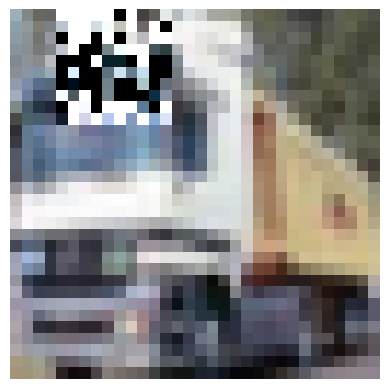

'truck'

In [27]:
show(X_mask)
predict(X_mask)

Now lets check the message dumper for a new message. This should show we have found an outlier.

In [28]:
!kubectl logs -n cifar10 $(kubectl get pod -n cifar10 -l app=hello-display -o jsonpath='{.items[0].metadata.name}')

2025/12/12 15:00:08 failed to parse observability config from env, falling back to default config
2025/12/12 15:00:08 failed to correctly initialize otel resource, resouce may be missing some attributes: the environment variable "SYSTEM_NAMESPACE" is not set, not adding "k8s.namespace.name" to otel attributes
☁️  cloudevents.Event
Context Attributes,
  specversion: 1.0
  type: io.seldon.serving.inference.outlier
  source: io.seldon.serving.cifar10od
  id: 7740b269-da42-4e6f-a451-8ba8a239b97f
Extensions,
  endpoint: model
  inferenceservicename: tfserving-cifar10
  knativearrivaltime: 2025-12-12T15:03:13.825723818Z
  modelid: resnet32
  namespace: cifar10
  protocol: tensorflow
  requestid: 960f455d-8fee-4cb0-a560-5d2b64870634
  traceparent: 00-4c9e3317bd45a88e22a7ab1a787f47f2-a191b6f624f17efe-00
Data,
  {"data": {"is_outlier": [0]}, "meta": {"name": "OutlierVAE", "detector_type": "offline", "data_type": "image"}}
☁️  cloudevents.Event
Context Attributes,
  specversion: 1.0
  type: io.s

## Tear Down

In [37]:
!kubectl delete ns cifar10

namespace "cifar10" deleted
